In [1]:
from pyspark.sql import SparkSession
import pyspark.pandas
import pandas as pd
from pyspark.sql.types import IntegerType
from functools import reduce 
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
import numpy as np
from pyspark.sql import types 
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import date_format
from pyspark.sql.types import DateType
from pyspark.sql.functions import quarter
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import hour, col
from pyspark.sql.functions import when
import statsmodels
from statsmodels.tsa.stattools import coint
import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px



In [2]:
#create spark session

spark = SparkSession.builder.master("local[*]").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

# import dataser

df_pr_co = spark.read.csv("prices_competitor.csv", header= True, inferSchema= True)
df_pr_ca = spark.read.csv("product_catalog.csv", header= True, inferSchema= True)


# DATA MANIPOULATION: Brief EDA and dataset merging

## PRODUCT CATALOG

In [3]:
df_pr_ca.show(5)

+----------+----------+----------+----------+-----------+----------+
|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+----------+----------+----------+-----------+----------+
|    143226|      2259|      1412|      1412|        522|      2719|
|    106100|      2880|      2856|      1169|        309|      1937|
|    149306|      2880|      2856|      4877|        455|      3618|
|    160649|       624|      2291|       601|        543|      2194|
|    124455|      1676|      2193|      2409|        289|      3120|
+----------+----------+----------+----------+-----------+----------+
only showing top 5 rows



In [4]:
# check the lengh of the dataset
print((df_pr_ca.count(), len(df_pr_ca.columns)))


(50, 6)


In [5]:
df_pr_ca.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- coded_cat1: integer (nullable = true)
 |-- coded_cat2: integer (nullable = true)
 |-- coded_cat3: integer (nullable = true)
 |-- coded_brand: integer (nullable = true)
 |-- coded_name: integer (nullable = true)



In [6]:
# checking for null values

null_df = df_pr_ca.select([count(when(col(c).contains('None') |\
                        col(c).contains('NULL')|\
                        (col(c) == '')|\
                        col(c).isNull() |\
                        isnan(c), c
                          )).alias(c)
                        for c in df_pr_ca.columns])

null_df.show()

+----------+----------+----------+----------+-----------+----------+
|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+----------+----------+----------+-----------+----------+
|         0|         0|         0|         0|          0|         0|
+----------+----------+----------+----------+-----------+----------+



## PRICES COMPETITOR

In [7]:
df_pr_co.show()

+-------------------+---------+----------+-----+
|          comp_date|seller_id|product_id|price|
+-------------------+---------+----------+-----+
|2021-01-01 00:00:00|       23|    112437| 7999|
|2021-01-01 00:00:00|       24|    112437| 8499|
|2021-01-01 00:00:00|       26|    112437| 6990|
|2021-01-01 00:00:00|       41|    112437| 7400|
|2021-01-01 00:00:00|       48|    112437| 8499|
|2021-01-01 00:00:00|      180|    112437| 7299|
|2021-01-01 00:00:00|      188|    112437| 7490|
|2021-01-01 00:00:00|       23|    110675| 3599|
|2021-01-01 00:00:00|       24|    110675| 3649|
|2021-01-01 00:00:00|       26|    110675| 3649|
|2021-01-01 00:00:00|       41|    110675| 2790|
|2021-01-01 00:00:00|       48|    110675| 3649|
|2021-01-01 00:00:00|      180|    110675| 3490|
|2021-01-01 00:00:00|      188|    110675| 3690|
|2021-01-01 00:00:00|      407|    110675| 2690|
|2021-01-01 00:00:00|       23|    103851| 1190|
|2021-01-01 00:00:00|       24|    103851| 1190|
|2021-01-01 00:00:00

In [8]:
# check the lengh of the dataset
print((df_pr_co.count(), len(df_pr_co.columns)))


(82865, 4)


In [9]:
df_pr_co.printSchema()

root
 |-- comp_date: timestamp (nullable = true)
 |-- seller_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- price: integer (nullable = true)



In [10]:
df_pr_co = df_pr_co.withColumn("comp_date", df_pr_co["comp_date"].cast(StringType()))


In [11]:

# checking for null values

null_df = df_pr_co.select([count(when(col(c).contains('None') |\
                        col(c).contains('NULL')|\
                        (col(c) == '')|\
                        col(c).isNull() |\
                        isnan(c), c
                          )).alias(c)
                        for c in df_pr_co.columns])

null_df.show()

+---------+---------+----------+-----+
|comp_date|seller_id|product_id|price|
+---------+---------+----------+-----+
|        0|        0|         0|    0|
+---------+---------+----------+-----+



## JOIN

In [12]:
df = df_pr_co.join(df_pr_ca,df_pr_co.product_id ==  df_pr_ca.product_id,"inner")
df.show(5)

+-------------------+---------+----------+-----+----------+----------+----------+----------+-----------+----------+
|          comp_date|seller_id|product_id|price|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+-------------------+---------+----------+-----+----------+----------+----------+----------+-----------+----------+
|2021-01-01 00:00:00|       23|    112437| 7999|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01 00:00:00|       24|    112437| 8499|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01 00:00:00|       26|    112437| 6990|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01 00:00:00|       41|    112437| 7400|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01 00:00:00|       48|    112437| 8499|    112437|      2259|       944|      1763|        542|      3142|
+-------------------+---------+----------+-----+----------+----------+--

In [13]:
df.printSchema()

root
 |-- comp_date: string (nullable = true)
 |-- seller_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- coded_cat1: integer (nullable = true)
 |-- coded_cat2: integer (nullable = true)
 |-- coded_cat3: integer (nullable = true)
 |-- coded_brand: integer (nullable = true)
 |-- coded_name: integer (nullable = true)



In [14]:
#checking lenght of the dataset for the data consistency of the inner join
print((df.count(), len(df.columns)))
print((df_pr_co.count(), len(df_pr_co.columns)))



(82865, 10)
(82865, 4)


the longest dataset (prices competitor) of the join operation is of the same lenght of the new df.

## more data modelling on the final dataset

In [15]:
# cleaning date column and converting it to datetype format
df = df.withColumn("comp_date",df['comp_date'].cast(DateType()))

In [16]:
df.printSchema()

root
 |-- comp_date: date (nullable = true)
 |-- seller_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- coded_cat1: integer (nullable = true)
 |-- coded_cat2: integer (nullable = true)
 |-- coded_cat3: integer (nullable = true)
 |-- coded_brand: integer (nullable = true)
 |-- coded_name: integer (nullable = true)



In [17]:
# Create five different time intervals with quartiles. This is fundamental to have a more precise picture of the situation. The intervals are:
# first quarter : from January to March
# second quarter: from April to June
# third quarter : from July to September
# fourth quarter : from October to December

df = df.withColumn('quarter',quarter(df.comp_date))
black_friday = df.filter(F.col("comp_date").between(pd.to_datetime('2021-11-01'),pd.to_datetime('2021-11-30')))
df.show()

+----------+---------+----------+-----+----------+----------+----------+----------+-----------+----------+-------+
| comp_date|seller_id|product_id|price|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|quarter|
+----------+---------+----------+-----+----------+----------+----------+----------+-----------+----------+-------+
|2021-01-01|       23|    112437| 7999|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|       24|    112437| 8499|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|       26|    112437| 6990|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|       41|    112437| 7400|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|       48|    112437| 8499|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|      180|    112437| 7299|    112437|      2259|       944|      17

In [18]:
# remove duplicate product_id column

df_cols = df.columns
# get index of the duplicate columns
duplicate_col_index = list(set([df_cols.index(c) for c in df_cols if df_cols.count(c) == 2]))

# rename by adding suffix '_duplicated'
for i in duplicate_col_index:
    df_cols[i] = df_cols[i] + '_duplicated'

# rename the column in DF
df = df.toDF(*df_cols)

# remove flagged columns
cols_to_remove = [c for c in df_cols if '_duplicated' in c]
df =  df.drop(*cols_to_remove)
df.show()

+----------+---------+-----+----------+----------+----------+----------+-----------+----------+-------+
| comp_date|seller_id|price|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|quarter|
+----------+---------+-----+----------+----------+----------+----------+-----------+----------+-------+
|2021-01-01|       23| 7999|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|       24| 8499|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|       26| 6990|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|       41| 7400|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|       48| 8499|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|      180| 7299|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|      188| 7490|    112437|      2259|       944|   

In [19]:
# filtered the dataset in order to consider only the product sold by seller 24

df_24 = df.filter(df.seller_id == 24)
df_24.show(5)


+----------+---------+-----+----------+----------+----------+----------+-----------+----------+-------+
| comp_date|seller_id|price|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|quarter|
+----------+---------+-----+----------+----------+----------+----------+-----------+----------+-------+
|2021-01-01|       24| 8499|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|       24| 3649|    110675|      2180|       613|      2275|        544|      2531|      1|
|2021-01-01|       24| 1190|    103851|      2259|       944|      1867|        367|      2979|      1|
|2021-01-01|       24| 3990|    107645|      2259|      1714|       720|        522|      1782|      1|
|2021-01-01|       24| 3990|    110853|      2259|      2015|       493|        522|      1709|      1|
+----------+---------+-----+----------+----------+----------+----------+-----------+----------+-------+
only showing top 5 rows



In [20]:
len_df = df.count()
print("Number of items in the dataset", len_df)

len_24 = df_24.count()
print("Number of product 24 item in the dataset", len_24)

print("Our market share is" ,(len_24/len_df) )


Number of items in the dataset 82865
Number of product 24 item in the dataset 14945
Our market share is 0.1803535871598383


In [21]:
# most presesent seller in the dataset

market_share = df.groupBy('seller_id').count()
market_share = market_share.withColumn("market_share", market_share["count"]/len_df)
market_share.show()

+---------+-----+-------------------+
|seller_id|count|       market_share|
+---------+-----+-------------------+
|       26|13374|0.16139504012550535|
|       48|12577|0.15177698666505762|
|       41| 9159|0.11052917395764195|
|       23| 6396|0.07718578410667953|
|       24|14945| 0.1803535871598383|
|      490| 3980|0.04802992819646413|
|      188| 6452|0.07786158209135341|
|      180| 8746|0.10554516382067218|
|      407| 7236|0.08732275387678755|
+---------+-----+-------------------+



# Business analysis

## Which are the top sold 10 products ?
In order to understand the leaders and the followers for the key products sold by retailer 24, we investigate about the top 10 products sold by him and compared dinamicaly their pricece with the ones of all the other main competitors

In [22]:
df_sd = spark.read.csv("sales_data.csv", header= True, inferSchema= True)
df_sd.show()


+-------------------+----------+--------+---------------+-----------------+-----------+-------------+--------------+
|          sale_date|product_id|quantity|sales_price_tax|regular_price_tax|sales_price|regular_price|purchase_price|
+-------------------+----------+--------+---------------+-----------------+-----------+-------------+--------------+
|2021-01-02 00:00:00|    110853|       1|         3990.0|           8322.0|     3325.0|    6935.1852|        2833.7|
|2021-01-03 00:00:00|    157318|       1|         4590.0|          12211.0|     3825.0|   10175.9259|        3481.2|
|2021-01-04 00:00:00|    107645|       3|         1990.0|           4433.0|     1658.0|    3694.4444|       1369.29|
|2021-01-04 00:00:00|    110853|      12|         3990.0|           8322.0|     3325.0|    6935.1852|        2833.7|
|2021-01-04 00:00:00|    110908|       1|         4490.0|           7767.0|     3742.0|    6472.2222|        3722.0|
|2021-01-04 00:00:00|    112376|       3|          379.0|       

In [23]:
# cleaning date column

df_sd = df_sd.withColumn("comp_date",df_sd['sale_date'].cast(DateType()))

In [24]:
# the most common item for seller 24
top_sell = df_sd.groupBy("product_id").count().orderBy(col('count').desc())
top_sell.show()


+----------+-----+
|product_id|count|
+----------+-----+
|    157318|  210|
|    107645|  185|
|    157317|  184|
|    103851|  179|
|    125506|  171|
|    128772|  168|
|    132284|  167|
|    112377|  162|
|    157316|  161|
|    134358|  155|
|    110908|  154|
|    143220|  154|
|    132842|  151|
|    134200|  147|
|    132408|  145|
|    154557|  145|
|    133888|  140|
|    154553|  131|
|    163385|  126|
|    161147|  125|
+----------+-----+
only showing top 20 rows



In [25]:

param= {
    "price":"mean",
    "coded_cat1":"first",
    "coded_cat2":"first",
    "coded_cat3":"first",
    "coded_brand":"first",
    "coded_name":"first",
    "quarter":"first",
}

df_grouped = df_24.groupby(["comp_date","seller_id","product_id"]).agg(param)


## understand price relationship

In [26]:
df.show()

+----------+---------+-----+----------+----------+----------+----------+-----------+----------+-------+
| comp_date|seller_id|price|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|quarter|
+----------+---------+-----+----------+----------+----------+----------+-----------+----------+-------+
|2021-01-01|       23| 7999|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|       24| 8499|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|       26| 6990|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|       41| 7400|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|       48| 8499|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|      180| 7299|    112437|      2259|       944|      1763|        542|      3142|      1|
|2021-01-01|      188| 7490|    112437|      2259|       944|   

In [27]:
## code for product price analyzis among all competitor

product = 107645 #choose the product here
period = [1,2,3,4]#select the quarter to analyze
blackfriday = [1]

df = df.withColumn('BLACKFRIDAY', F.when(F.col('comp_date').between (pd.to_datetime('2021-11-01'),pd.to_datetime('2021-11-30')), "Yes").otherwise("No"))



df_final_product = df[df.product_id == product]

df_final_product = df_final_product[df_final_product["quarter"].isin(period)]

df_final_product = df_final_product.groupBy("comp_date").pivot("seller_id").agg({"price":"max"}).sort("comp_date").fillna(0)


df_final_product.show()


+----------+----+----+----+----+----+----+----+----+---+
| comp_date|  23|  24|  26|  41|  48| 180| 188| 407|490|
+----------+----+----+----+----+----+----+----+----+---+
|2021-01-01|1999|3990|3990|1750|3990|1779|1990|2299|  0|
|2021-01-02|1999|3990|3990|1750|3990|1899|1990|2299|  0|
|2021-01-03|1999|3990|3990|1750|3990|1899|1990|2299|  0|
|2021-01-04|1999|3990|3990|1750|3990|1899|1990|2299|  0|
|2021-01-05|1999|1990|3990|1750|1990|1899|1990|2299|  0|
|2021-01-06|1999|1990|1990|1750|1990|1899|1990|2299|  0|
|2021-01-07|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-08|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-09|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-10|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-11|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-12|1999|1990|1990|1990|1990|1890|1990|2299|  0|
|2021-01-13|1999|1990|1990|1990|1990|1890|1990|2299|  0|
|2021-01-14|1999|1990|1990|1990|1990|1890|1990|2299|  0|
|2021-01-15|1999|1990|1990|1990

In [28]:
# shifht all the row down by 1 

w = Window().partitionBy().orderBy(col("comp_date"))

valueColumns = ['23', '24', '26', '41', '48', '180', '188', '407', '490']
df_final_product_shift = df_final_product.select(
    "comp_date",
    *[F.lag(c, offset=1).over(w).alias(c) for c in valueColumns]
).dropna(how= "any")


df_final_product_shift.show()

+----------+----+----+----+----+----+----+----+----+---+
| comp_date|  23|  24|  26|  41|  48| 180| 188| 407|490|
+----------+----+----+----+----+----+----+----+----+---+
|2021-01-02|1999|3990|3990|1750|3990|1779|1990|2299|  0|
|2021-01-03|1999|3990|3990|1750|3990|1899|1990|2299|  0|
|2021-01-04|1999|3990|3990|1750|3990|1899|1990|2299|  0|
|2021-01-05|1999|3990|3990|1750|3990|1899|1990|2299|  0|
|2021-01-06|1999|1990|3990|1750|1990|1899|1990|2299|  0|
|2021-01-07|1999|1990|1990|1750|1990|1899|1990|2299|  0|
|2021-01-08|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-09|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-10|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-11|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-12|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-13|1999|1990|1990|1990|1990|1890|1990|2299|  0|
|2021-01-14|1999|1990|1990|1990|1990|1890|1990|2299|  0|
|2021-01-15|1999|1990|1990|1990|1990|1890|1990|2299|  0|
|2021-01-16|1999|1990|1990|1990

In [29]:
# Enable Arrow-based columnar data 
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


In [30]:
# converting spark df to pandas for data visualization

pandasDF = df_final_product.toPandas()
pandasDF_shifted = df_final_product_shift.toPandas()
pandasDF_grouped = df_grouped.toPandas()
df_final_pd = df.toPandas()



In [31]:
# rename the column

dict2 = {'first(coded_name)': 'coded_name',
        'avg(price)': 'price',
        'first(coded_cat1)': 'coded_cat1',
        'first(quarter)': 'quarter',
        'first(coded_cat2)': 'coded_cat2',
        'first(coded_brand)': 'coded_brand',
        'first(coded_cat3)': 'coded_cat3'
        }

pandasDF_grouped.rename(columns=dict2,inplace=True)

In [32]:
#date format conversion

date_conversion = pd.to_datetime(pandasDF['comp_date'], format='%Y-%m-%d')
date_conversion2 = pd.to_datetime(pandasDF_shifted['comp_date'], format='%Y-%m-%d')
pandasDF['comp_date'] = date_conversion
pandasDF_shifted['comp_date'] = date_conversion2
pandasDF = pandasDF[1:]

In [33]:
# new index

pandasDF = pandasDF.set_index('comp_date')
pandasDF_shifted = pandasDF_shifted.set_index("comp_date")


In [34]:
# finding leader and followew

my_list = []
Leader = []
Follower = []
Cointegration = []
Beta = []

for i in pandasDF_shifted.columns:
    for j in pandasDF_shifted.columns:
        if (i!=j and pandasDF[i].corr(pandasDF_shifted[j])):
            Leader.append(j)
            Follower.append(i)
            my_list.append(pandasDF[i].corr(pandasDF_shifted[j]))
            Cointegration.append(coint(pandasDF_shifted[j], pandasDF[i])[1] )
            Beta.append(np.linalg.lstsq(pandasDF[i].values[:,np.newaxis], pandasDF[j].values, rcond=None)[0][0])
 
 
 
output = pd.DataFrame({'Leader':Leader, 'Follower':Follower,
                       'Value':my_list, 'Cointegration':Cointegration,'Beta':Beta})
 
sample = output.sort_values(by="Value", ascending=False)


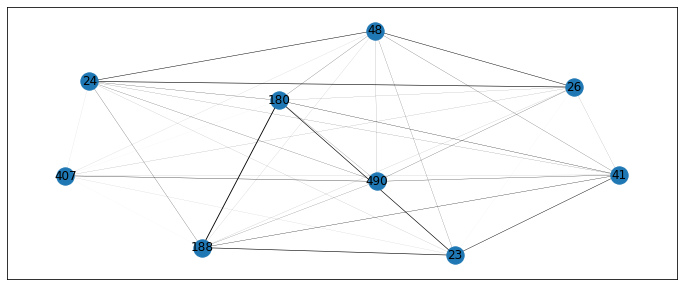

In [35]:
# network for the product selected, darker edges mean that the price movement between the two competitor is similar

G = nx.from_pandas_edgelist(sample,'Leader','Follower', edge_attr='Value')

durations = [i['Value'] for i in dict(G.edges).values()]
labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

fig, ax = plt.subplots(figsize=(12,5))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, ax = ax, label=True)

nx.draw_networkx_edges(G, pos, width = durations, ax=ax)
_ = nx.draw_networkx_labels(G, pos, labels, ax=ax)

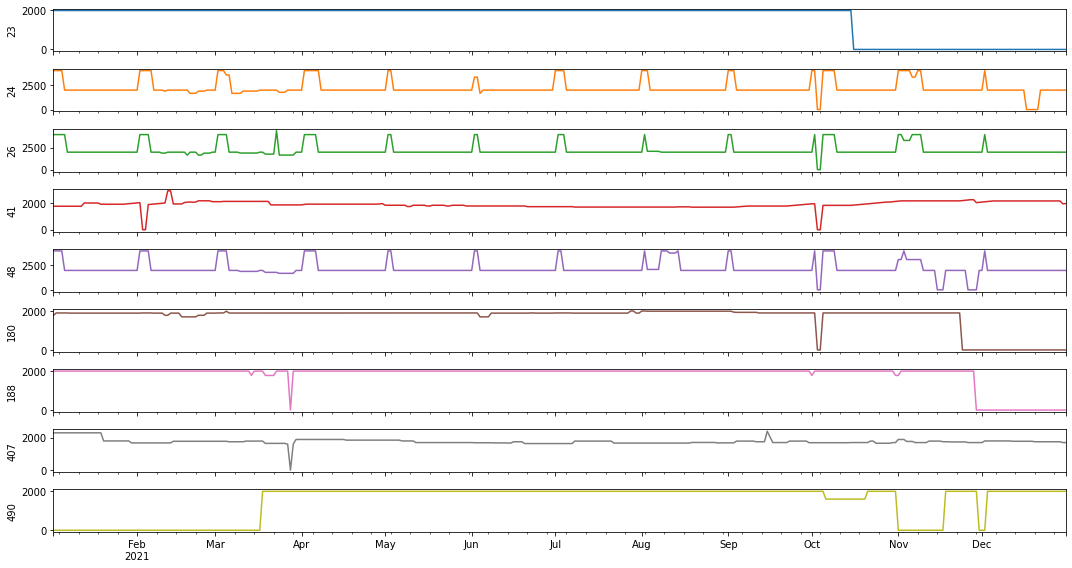

In [37]:
fig,ax = plt.subplots(len(pandasDF_shifted.columns), figsize=(15,8), sharex=True)

plot_cols = pandasDF_shifted.columns

pandasDF_shifted[plot_cols].plot(subplots=True, legend=False, ax=ax)

for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

In [38]:
from statsmodels.tsa.stattools  import   grangercausalitytests
grangercausalitytests(pandasDF_shifted[["26","24"]], maxlag=7) 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.8109 , p=0.0000  , df_denom=360, df_num=1
ssr based chi2 test:   chi2=23.0010 , p=0.0000  , df=1
likelihood ratio test: chi2=22.3016 , p=0.0000  , df=1
parameter F test:         F=22.8109 , p=0.0000  , df_denom=360, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=20.5291 , p=0.0000  , df_denom=357, df_num=2
ssr based chi2 test:   chi2=41.6333 , p=0.0000  , df=2
likelihood ratio test: chi2=39.4082 , p=0.0000  , df=2
parameter F test:         F=20.5291 , p=0.0000  , df_denom=357, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.9456 , p=0.0000  , df_denom=354, df_num=3
ssr based chi2 test:   chi2=48.7826 , p=0.0000  , df=3
likelihood ratio test: chi2=45.7564 , p=0.0000  , df=3
parameter F test:         F=15.9456 , p=0.0000  , df_denom=354, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=13.1465 , p=0.0000  

{1: ({'ssr_ftest': (22.810871204677227, 2.6059692896084454e-06, 360.0, 1),
   'ssr_chi2test': (23.000961798049538, 1.6192037035542207e-06, 1),
   'lrtest': (22.30164076530582, 2.330074331280653e-06, 1),
   'params_ftest': (22.810871204638126, 2.605969289658347e-06, 360.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (20.529122434026423, 3.637510315206042e-09, 357.0, 2),
   'ssr_chi2test': (41.63329031438412, 9.108479316985006e-10, 2),
   'lrtest': (39.408245520750825, 2.7708193663101777e-09, 2),
   'params_ftest': (20.529122433961298, 3.637510315418484e-09, 357.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (15.945574064127277, 9.566932300562862e-10, 354.0, 3),
   'ssr_chi2test': (48.78264607754192, 1.4511072231821087e-10, 3),
   'lrtest': (45.75636346931606, 6.389927865773075e-10, 3),
   'params_ftest': (15.945574064127749, 9.56693230055705e-10, 354.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1

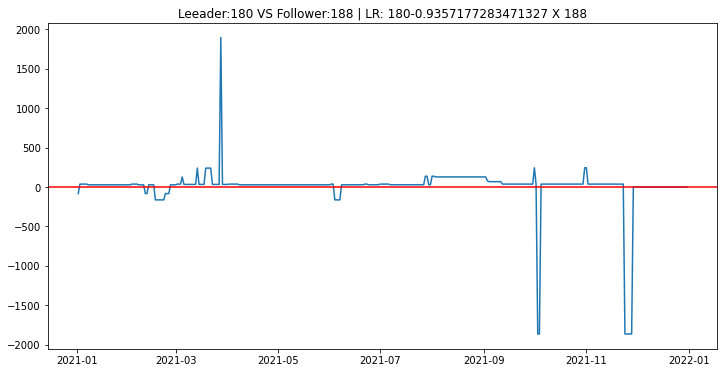

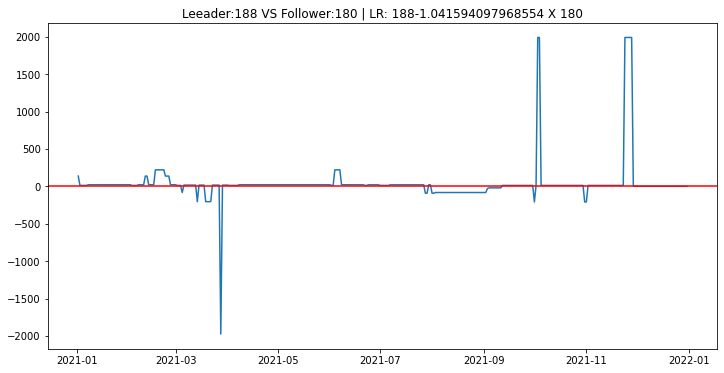

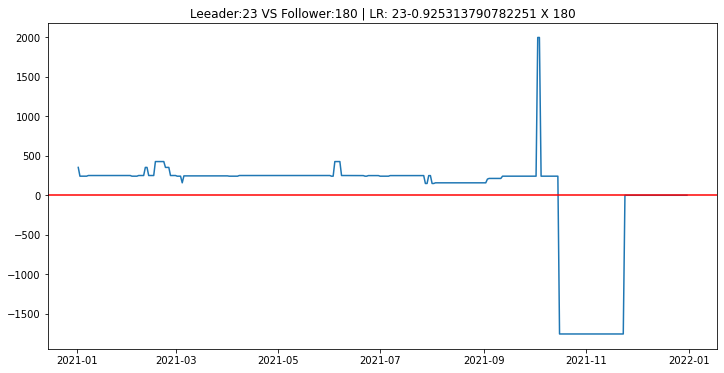

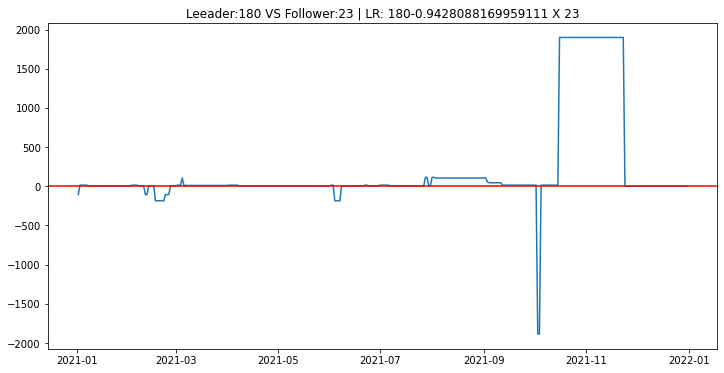

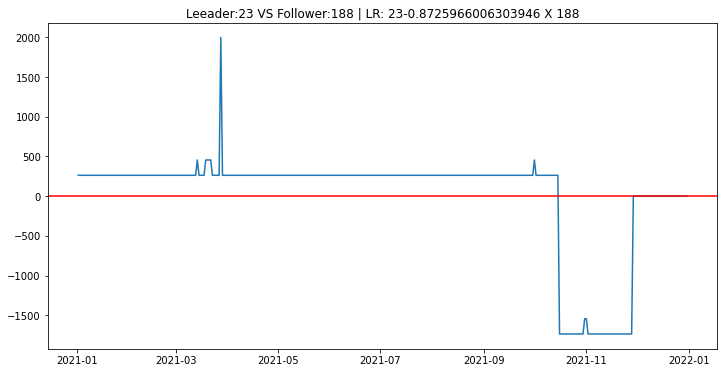

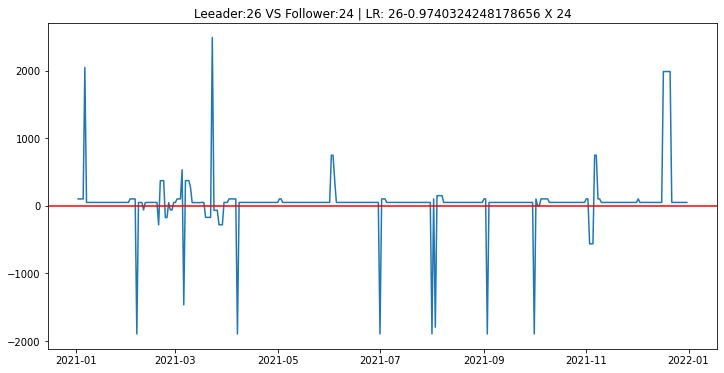

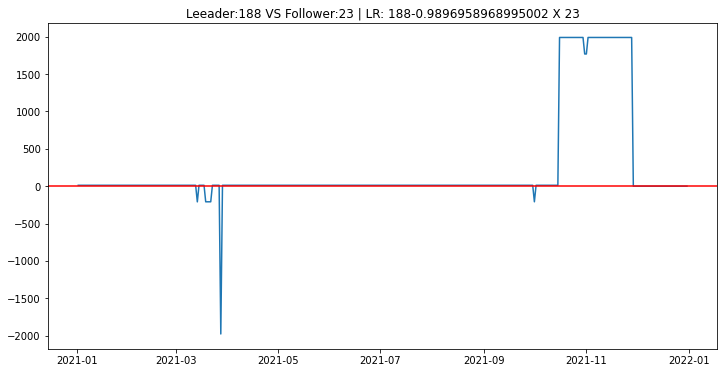

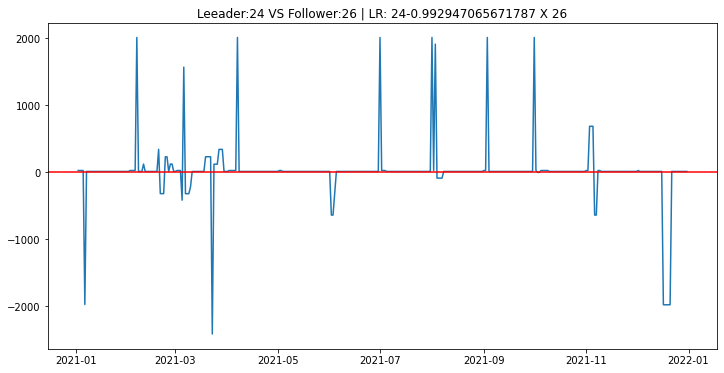

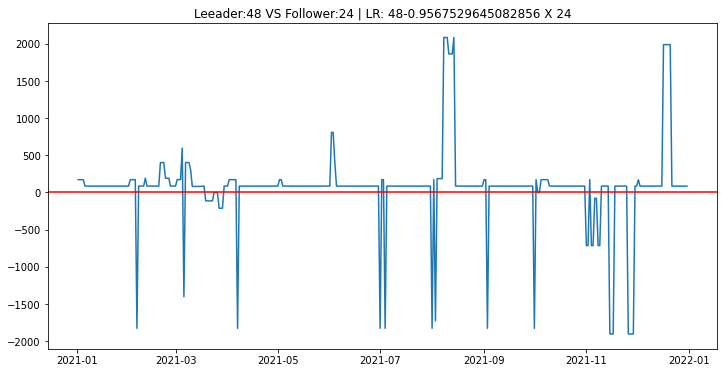

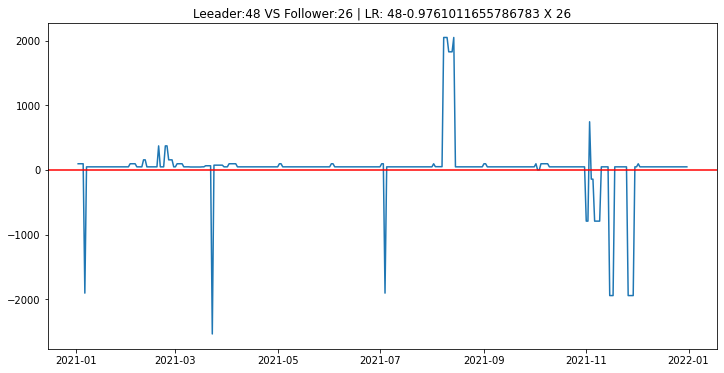

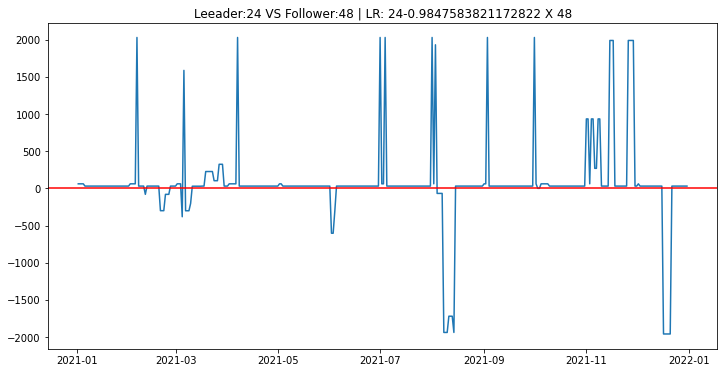

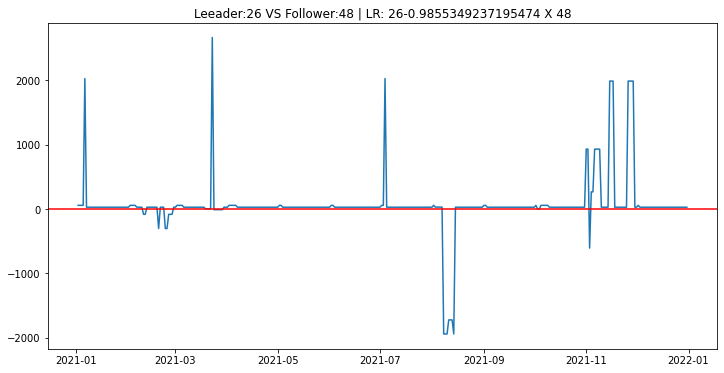

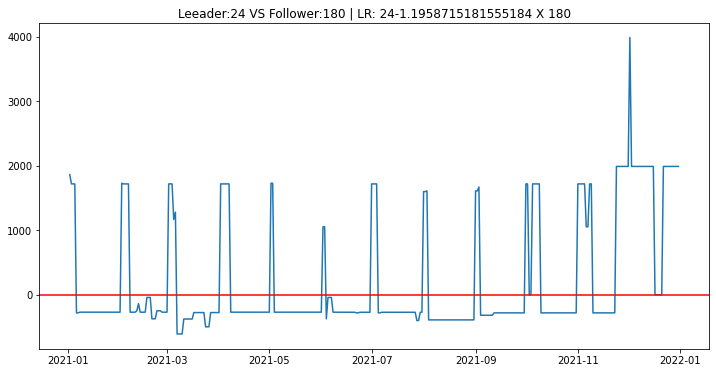

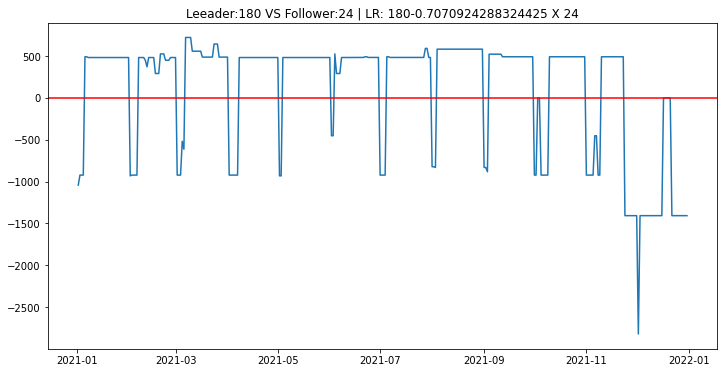

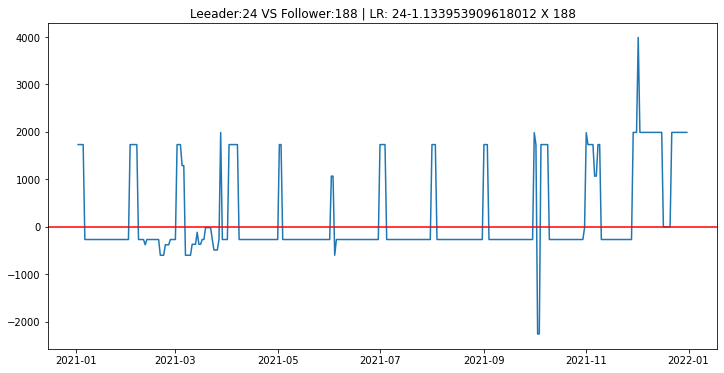

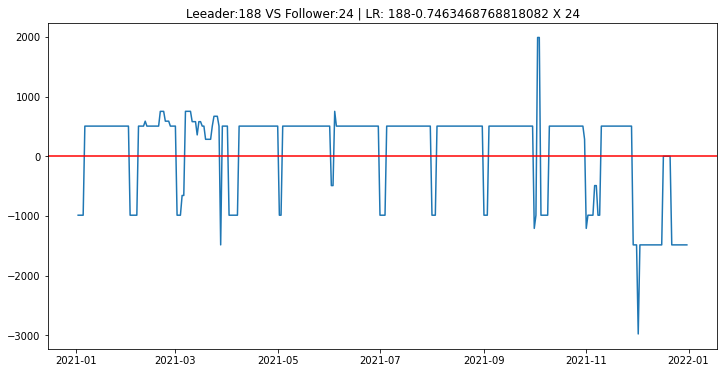

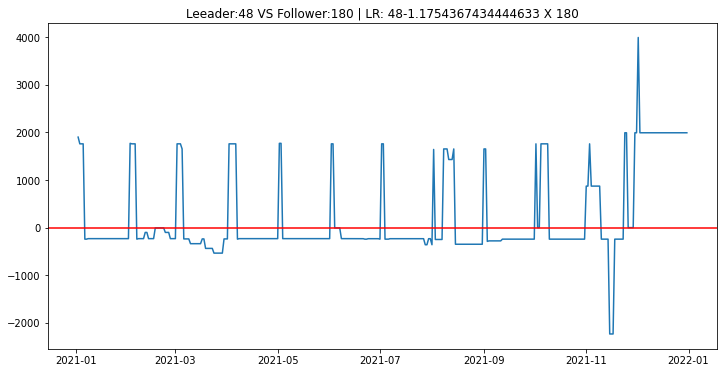

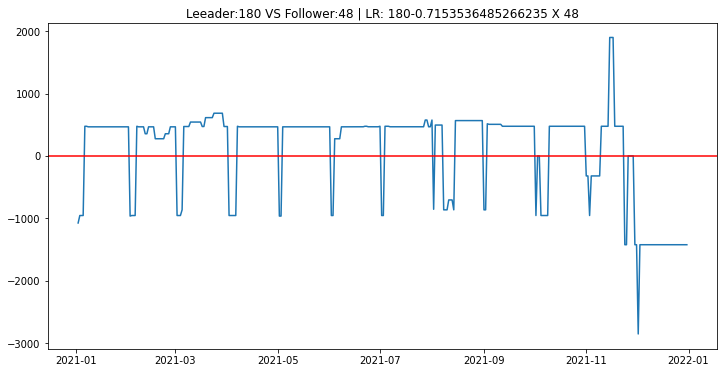

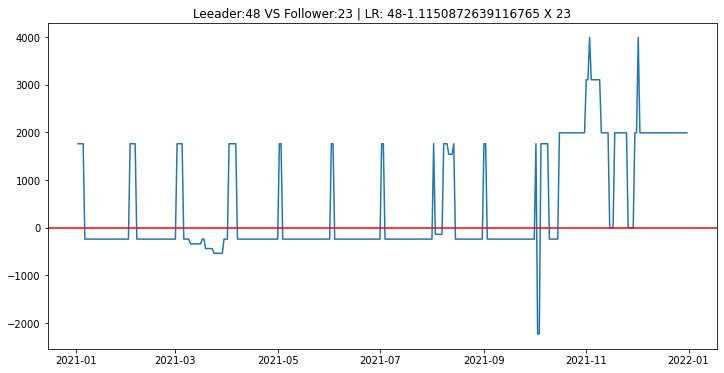

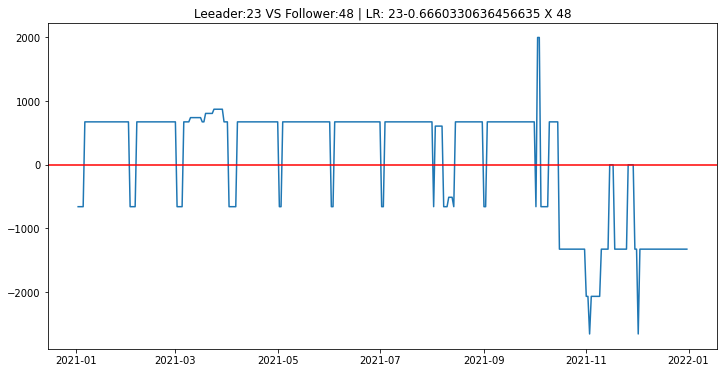

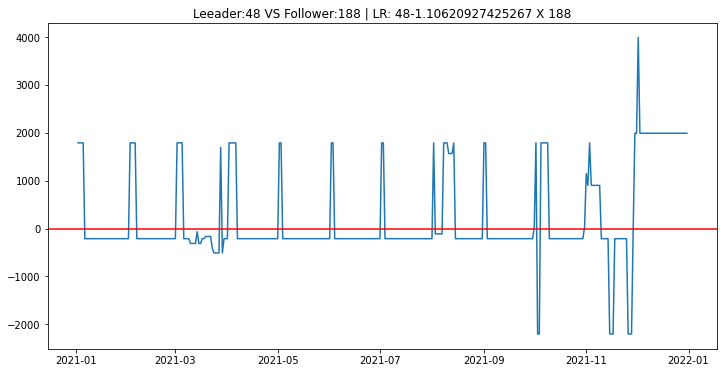

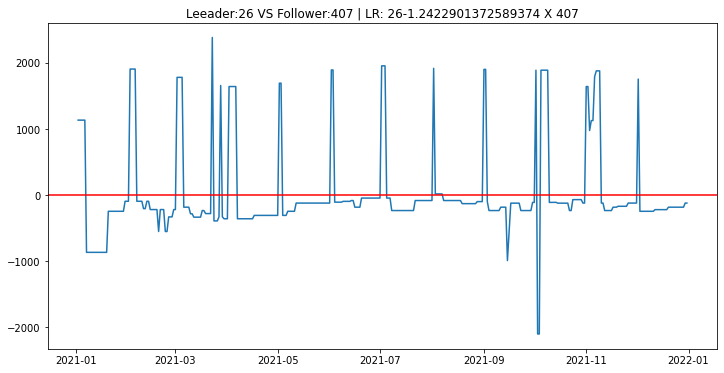

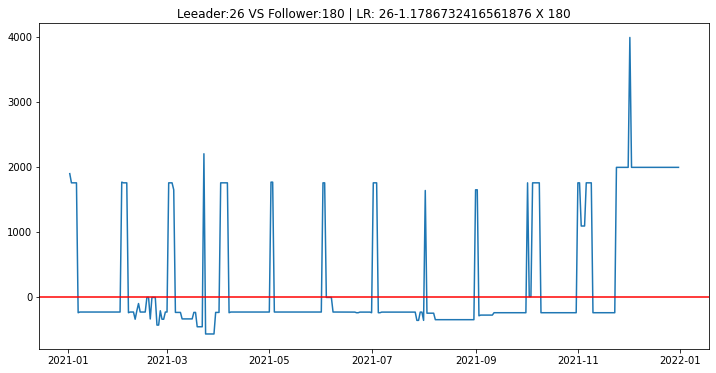

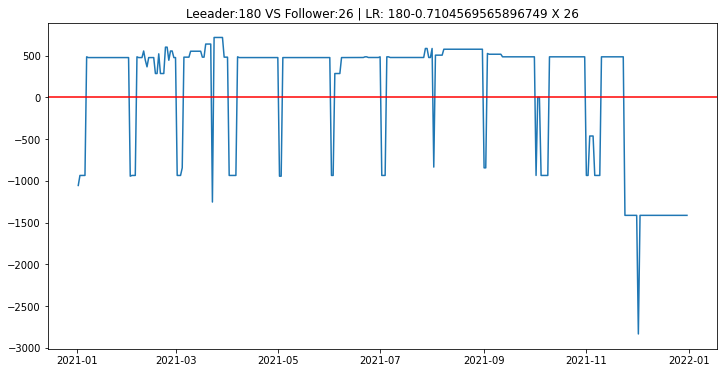

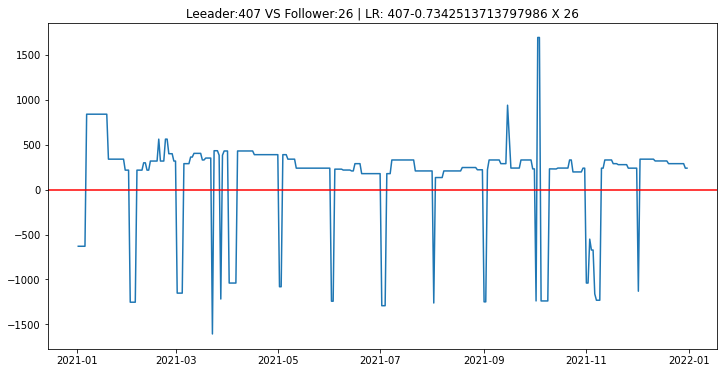

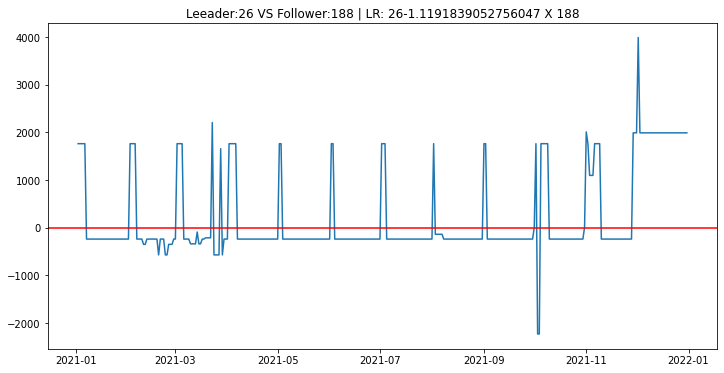

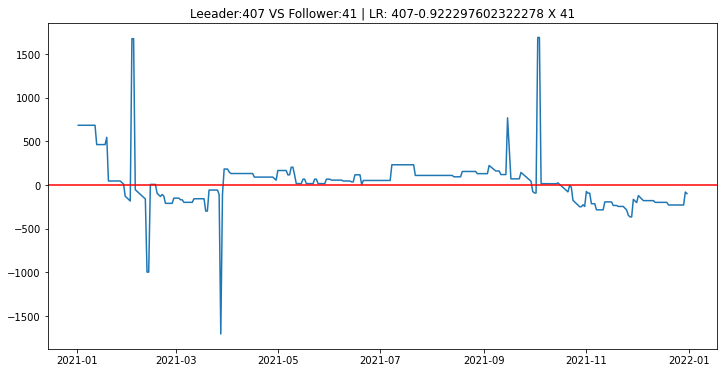

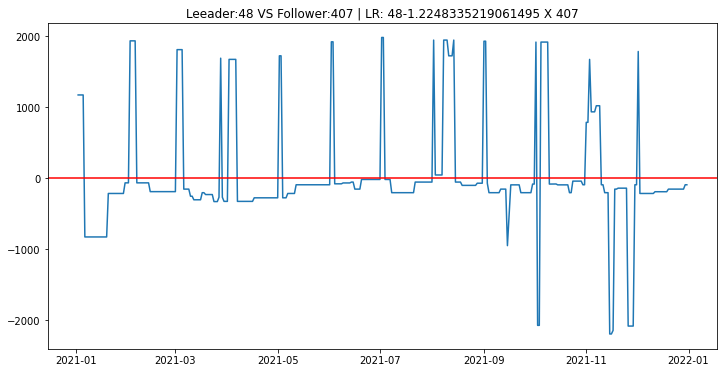

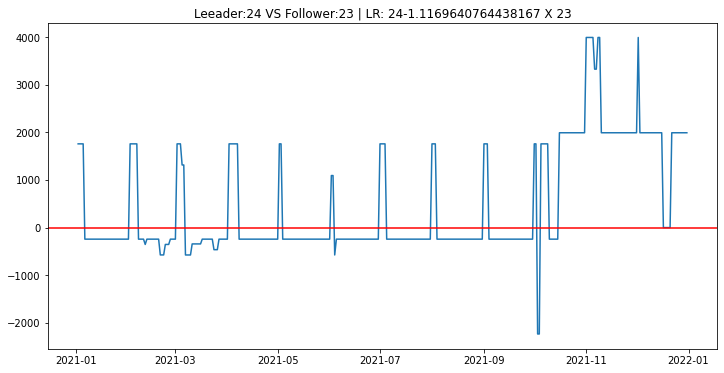

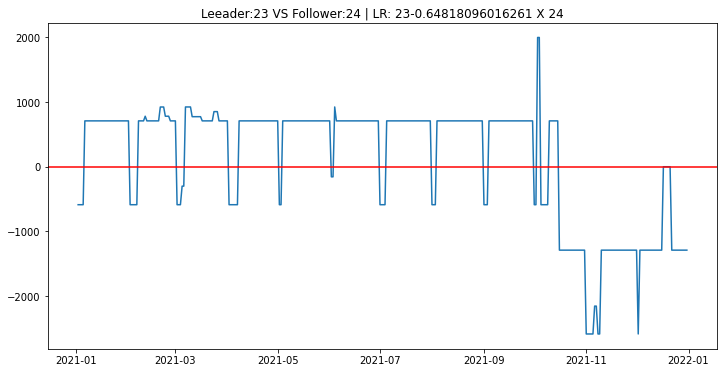

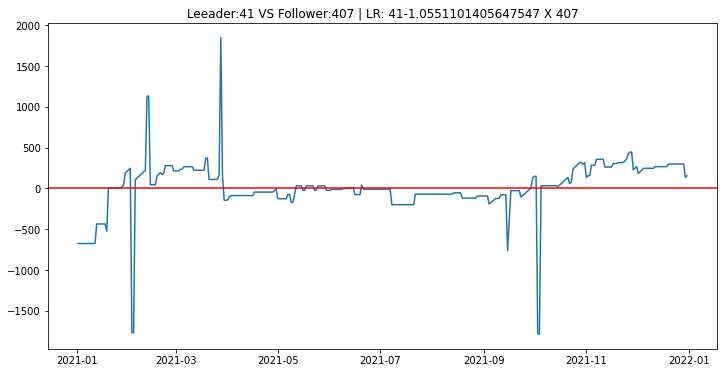

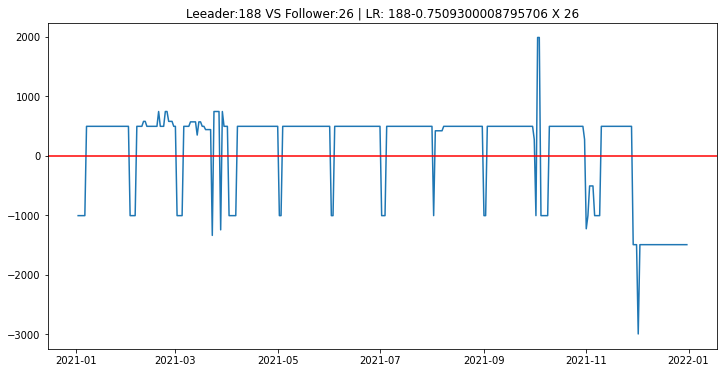

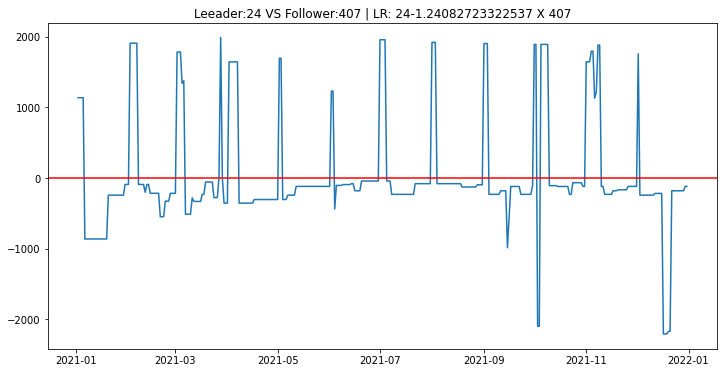

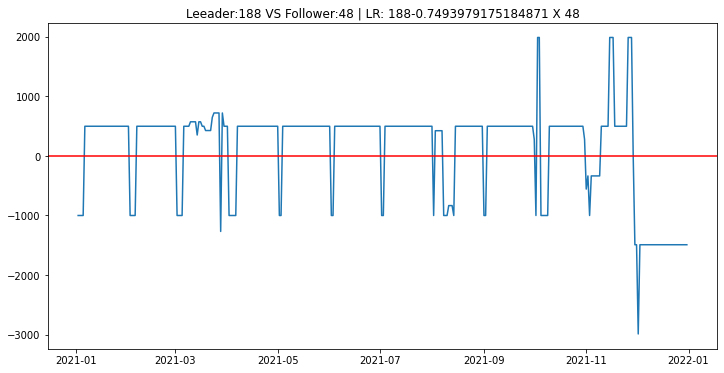

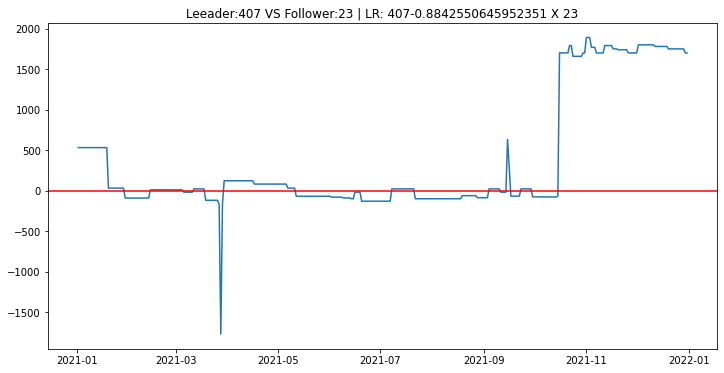

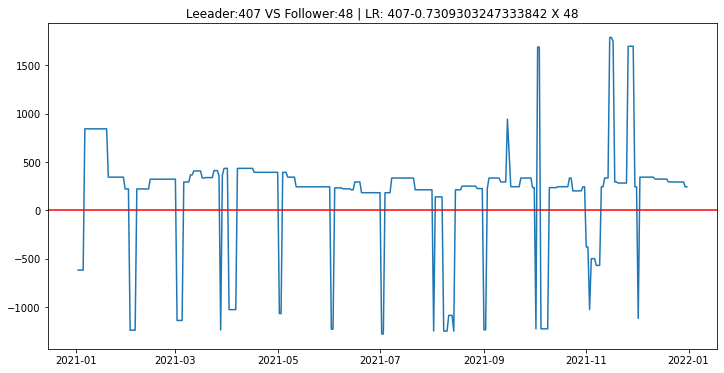

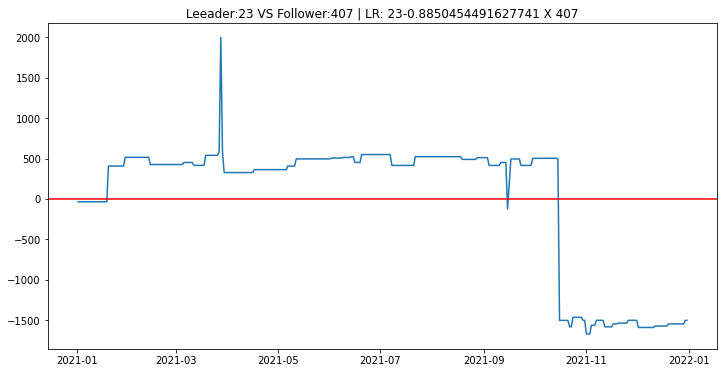

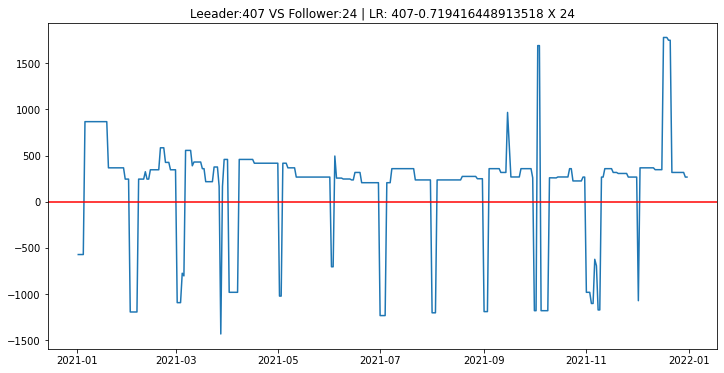

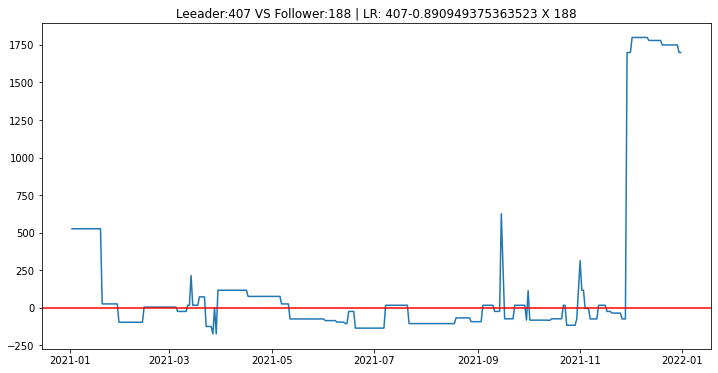

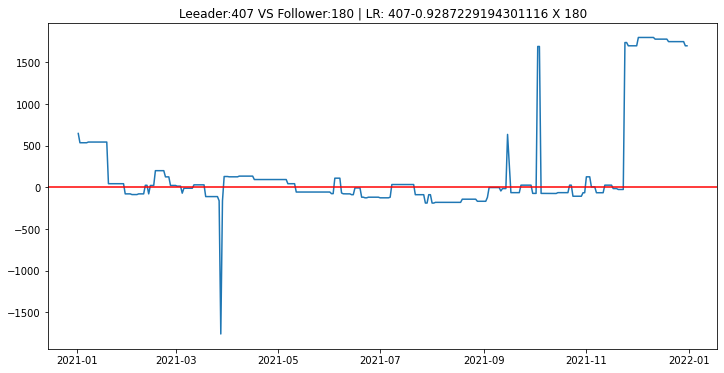

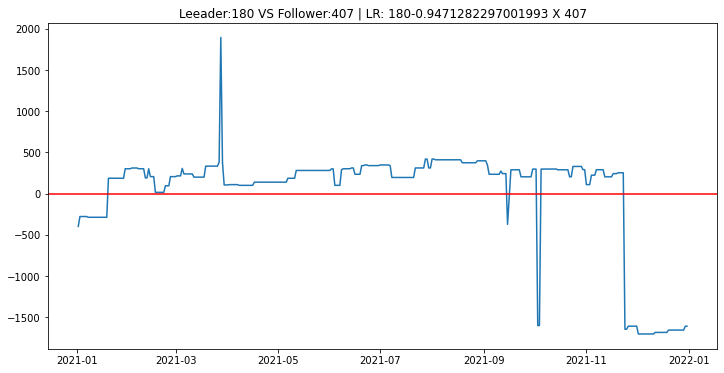

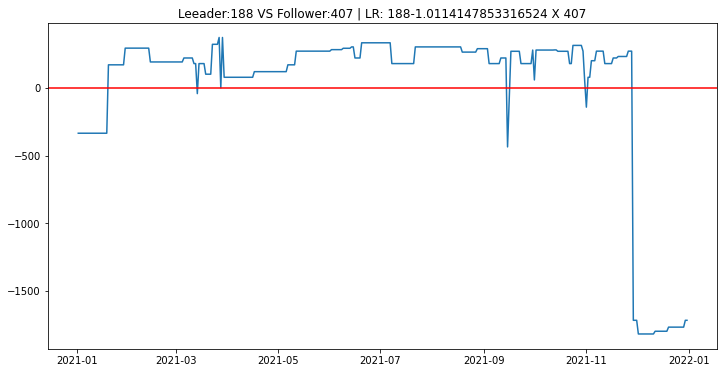

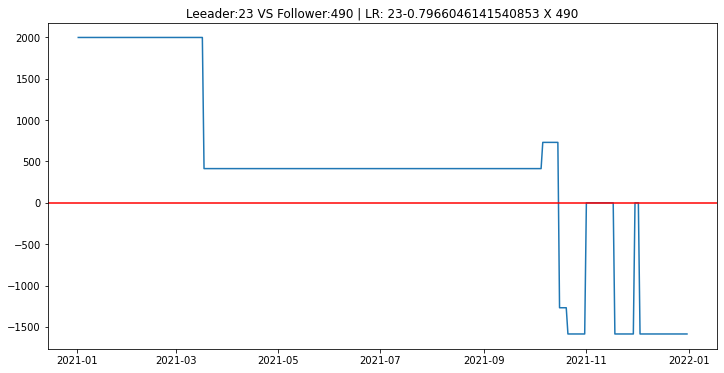

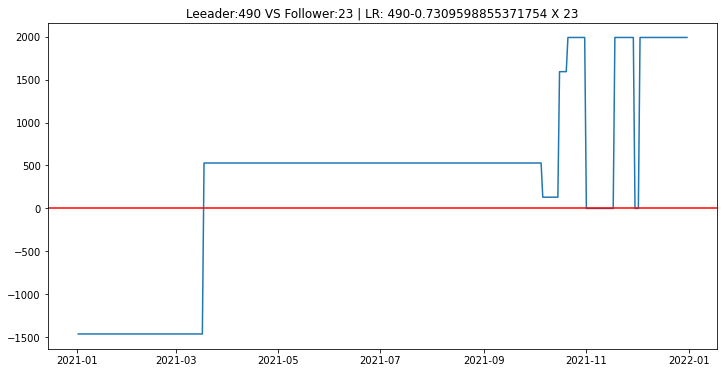

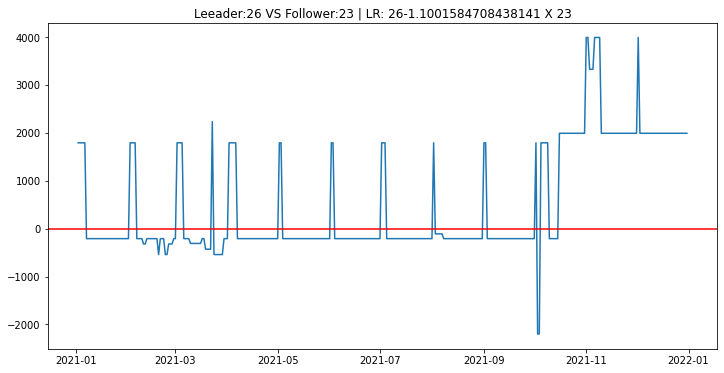

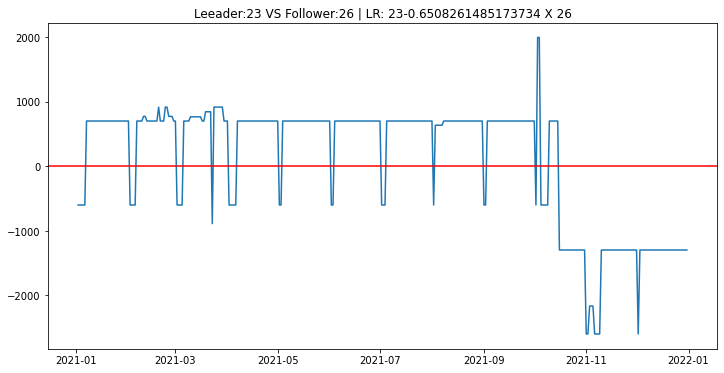

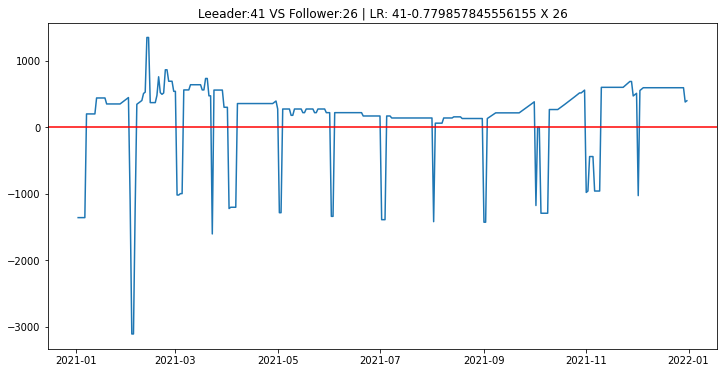

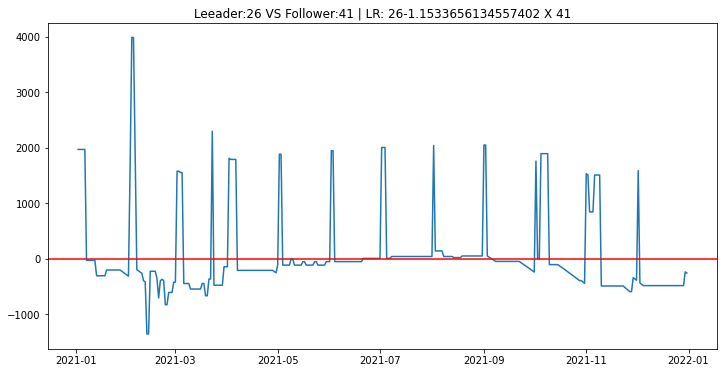

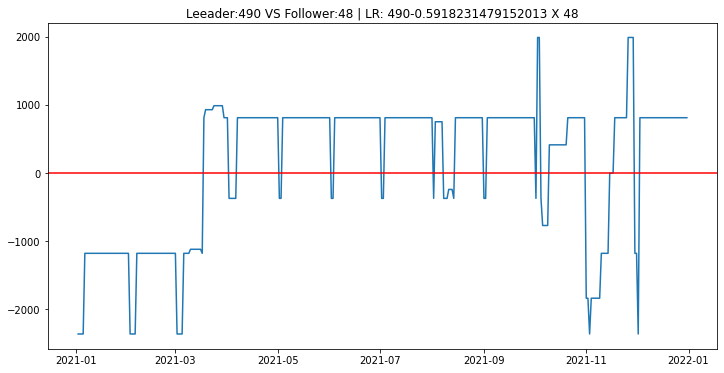

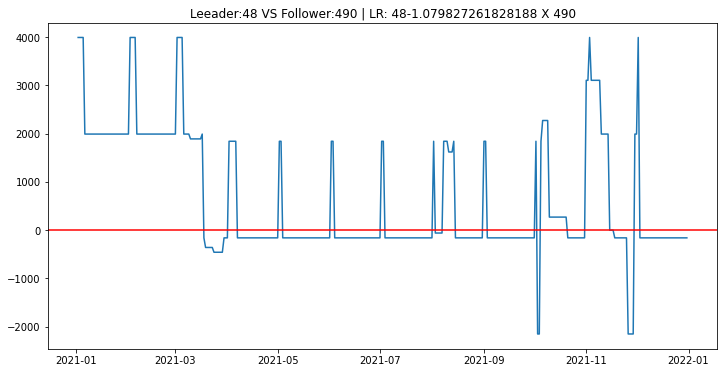

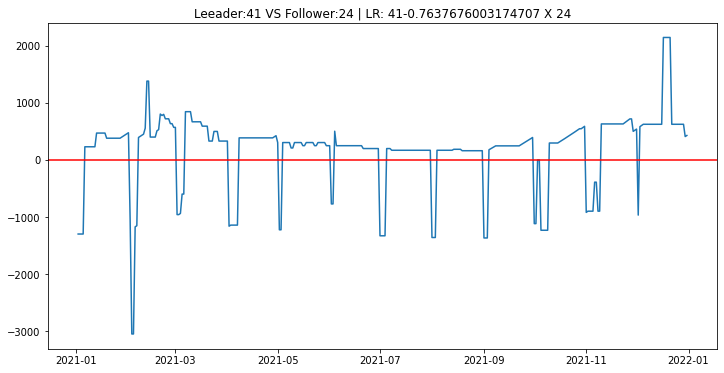

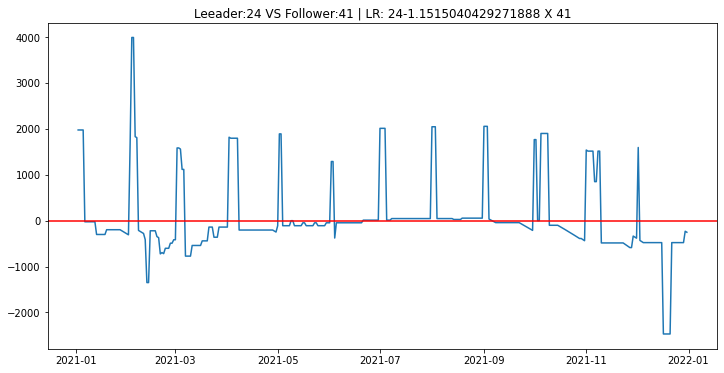

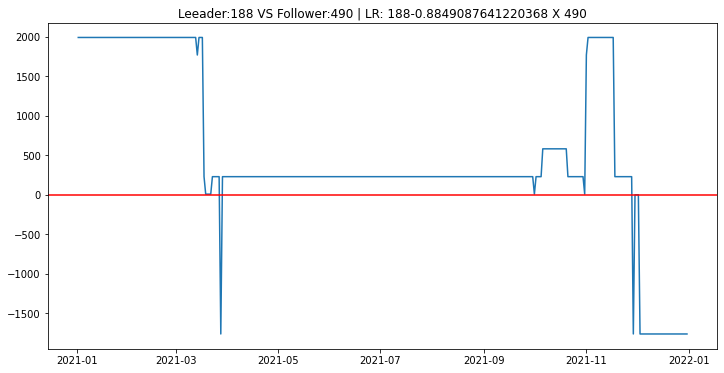

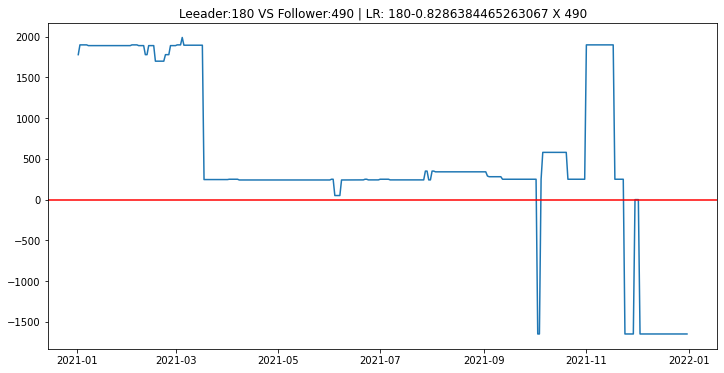

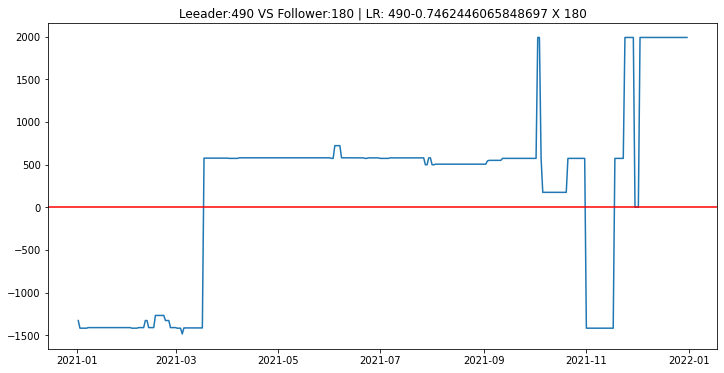

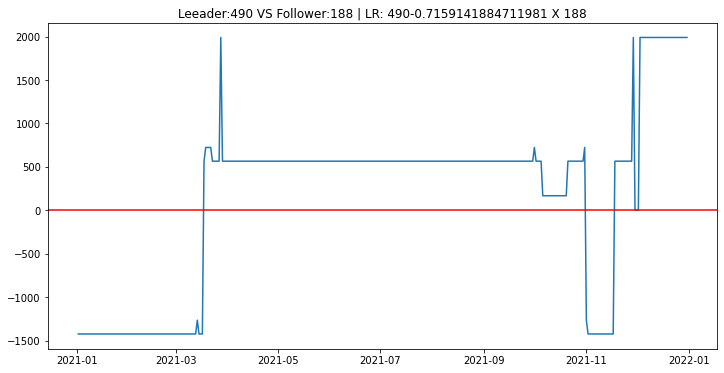

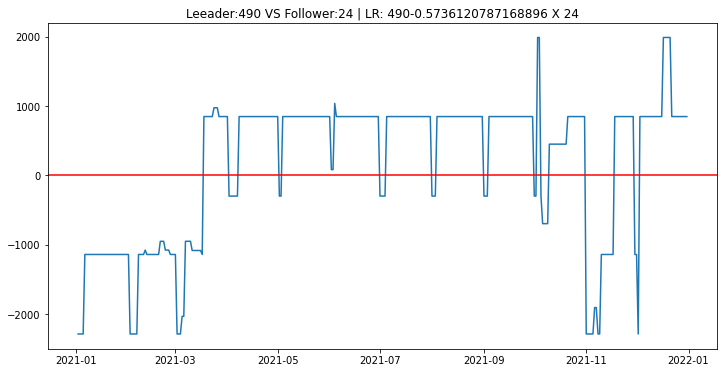

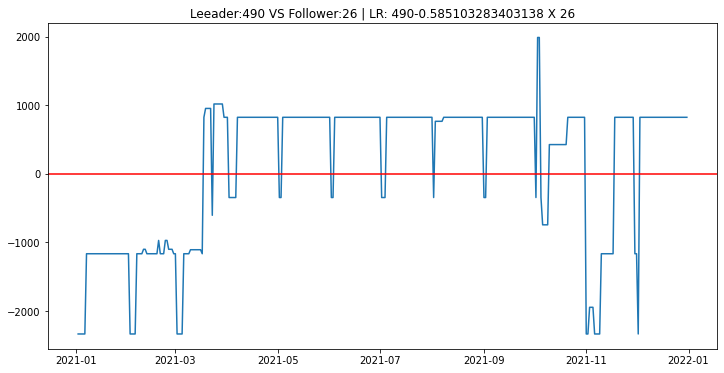

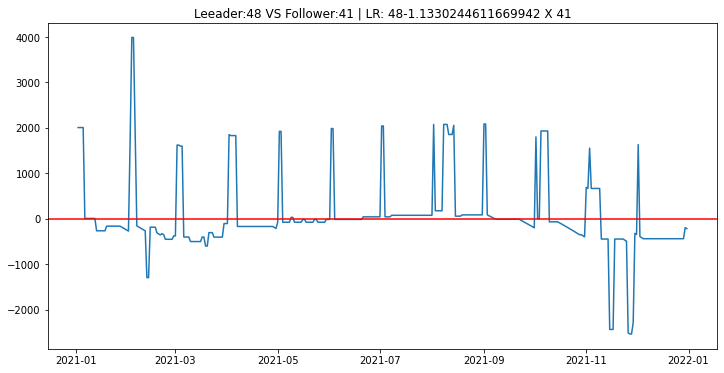

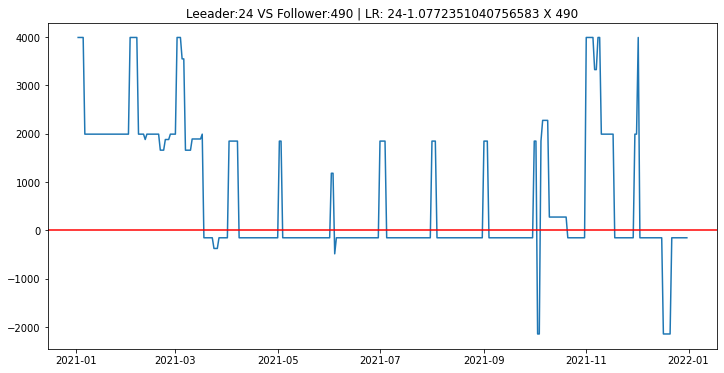

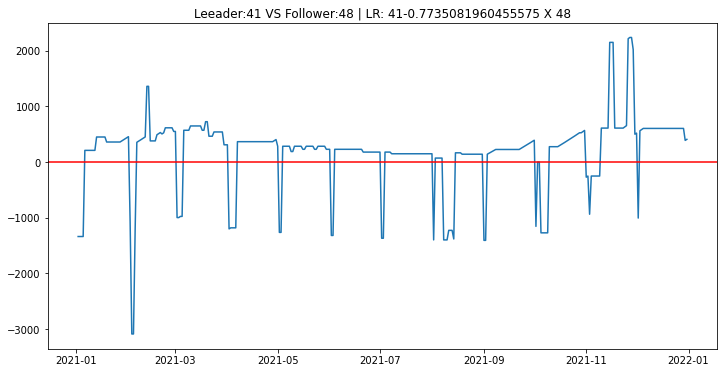

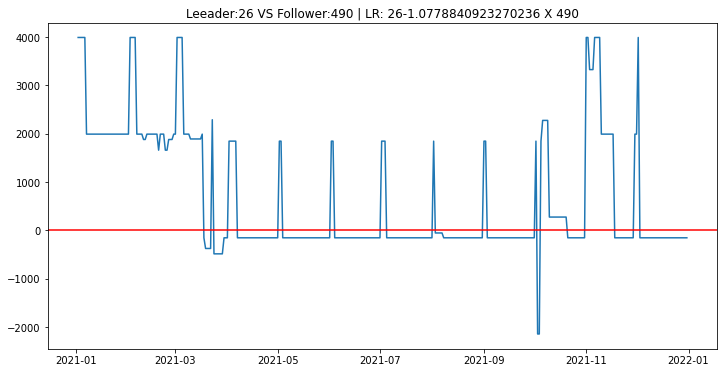

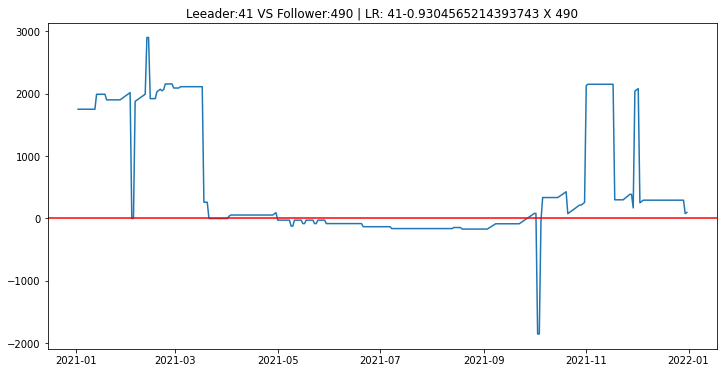

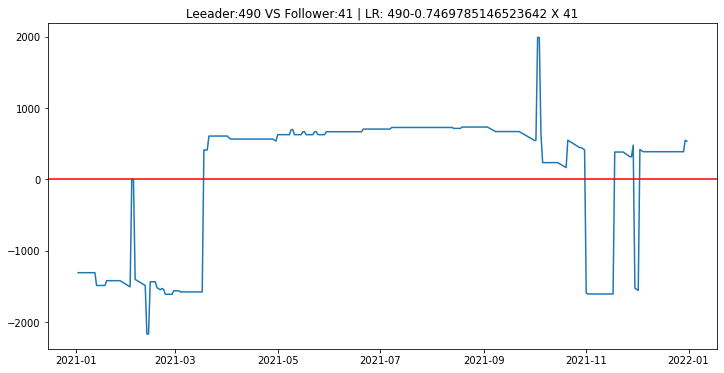

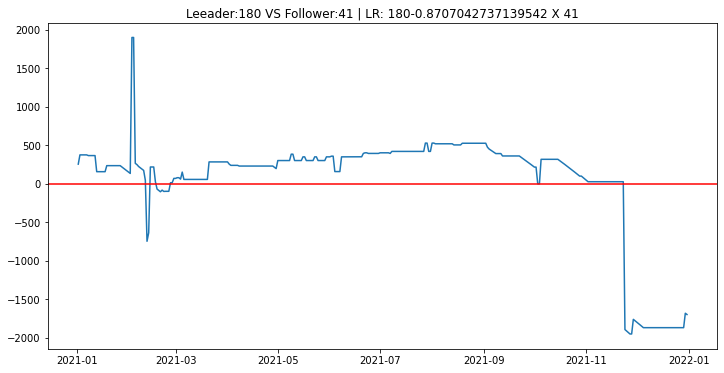

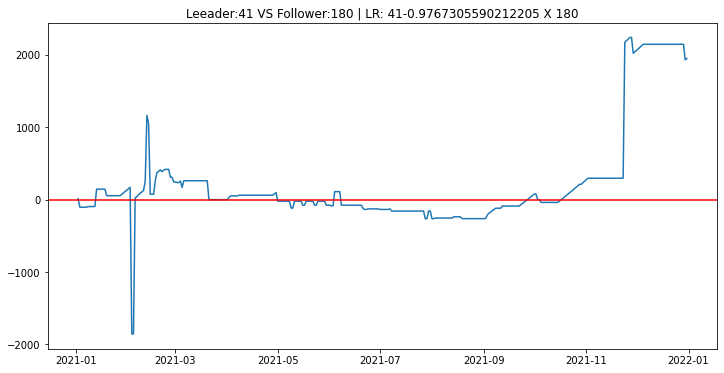

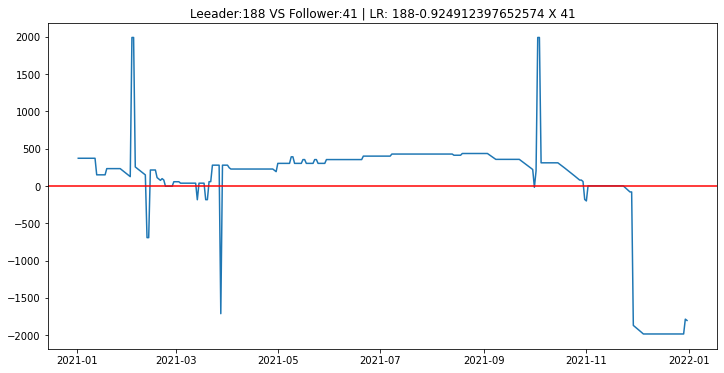

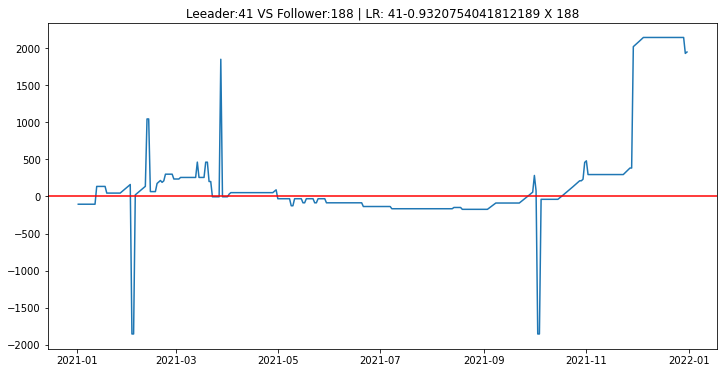

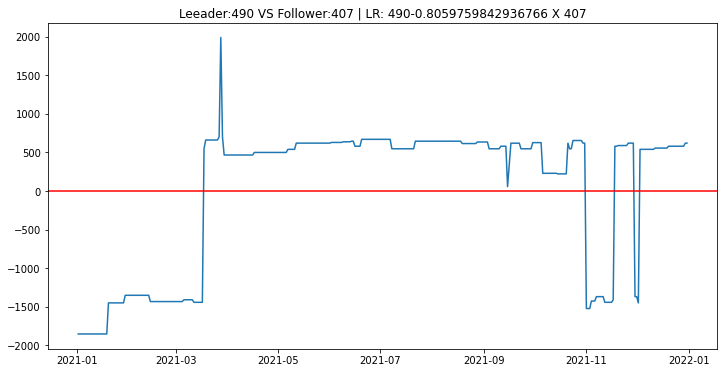

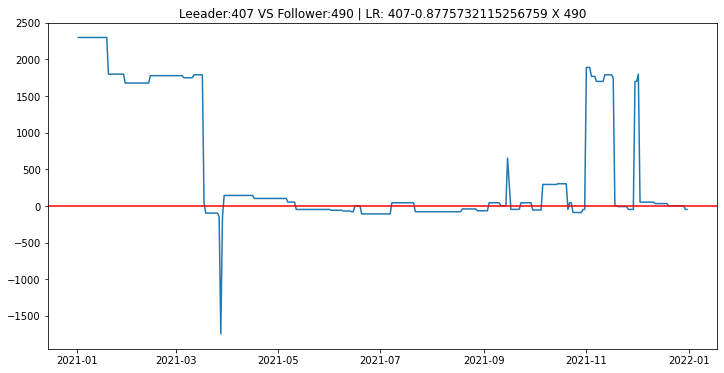

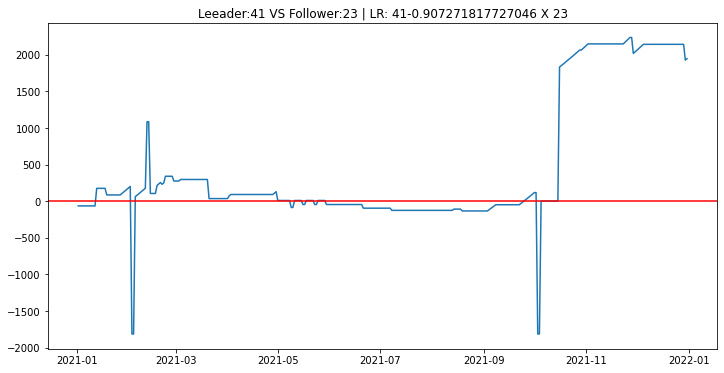

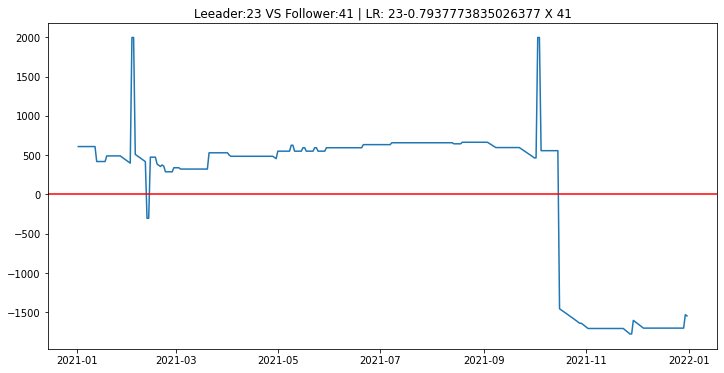

In [39]:
for i in range(sample.shape[0]):
    plt.figure(figsize=(12,6))
    plt.plot(pandasDF_shifted[sample.iloc[i]['Leader']] - pandasDF_shifted[sample.iloc[i]['Follower']]*sample.iloc[i]['Beta'])
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.title(str("Leeader:"+str(sample.iloc[i]['Leader']))+" VS Follower:"+  str(sample.iloc[i]['Follower'])+" | LR: "  + str(sample.iloc[i]['Leader'])+"-" + str(sample.iloc[i]['Beta']) + " X " + str(sample.iloc[i]['Follower']))
    plt.show()